In [121]:
%load_ext autoreload
%autoreload 2
import os
import sys
if 'google.colab' in sys.modules:
    %pip install -q skorch
    !git clone https://github.com/youyinnn/medical_imaging_imbalancing.git
    %cd /content/medical_imaging_imbalancing/src/isic
sys.path.insert(0, os.path.abspath('..'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
from isic_resnet import ISICResNet18, ISICResNet50, ISICResNet34
import isic_skorch_trainer
from isic_dataset import ISIC_2018
import torchvision.transforms as transforms

from isic_skorch_trainer import ResetedSkorchLRScheduler
from sklearn.metrics import top_k_accuracy_score
from torchvision.transforms import v2


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# torch.manual_seed(42);

isic_train = ISIC_2018(verbose=1)
isic_val = ISIC_2018(split='val', verbose=1)

isic_train_128 = ISIC_2018(size=(128, 128))
isic_val_128 = ISIC_2018(split='val', size=(128, 128))

isic_train_32 = ISIC_2018(size=(32, 32))
isic_val_32 = ISIC_2018(split='val', size=(32, 32))

isic_train_448 = ISIC_2018(size=(448))
isic_val_448 = ISIC_2018(split='val', size=(448))

isic_train_cutmixed = ISIC_2018(cut_mixed=True)

MEL: 1113 (11.11%), NV: 6705 (66.95%), BCC: 514 (5.13%), AKIEC: 327 (3.27%), BKL: 1099 (10.97%), DF: 115 (1.15%), VASC: 142 (1.42%)
MEL: 21 (10.88%), NV: 123 (63.73%), BCC: 15 (7.77%), AKIEC: 8 (4.15%), BKL: 22 (11.4%), DF: 1 (0.52%), VASC: 3 (1.55%)


### 18_256

In [21]:
max_epochs = 150
lr = 0.01

net_18_256_no_lrsc = isic_skorch_trainer.net_fit(
    isic_skorch_trainer.net_def(
        ISICResNet18, 
        net_name = '18_256_no_lrsc',
        classes=[torch.tensor, torch.tensor],    
        classifier_kwargs = dict(
            lr = lr,
            module__output_features = 7,
            train_split = isic_val,
            callbacks = []
            )
        ), 
isic_train, None, max_epochs)



 New training:
  epoch    train_loss    valid_acc    valid_f1    valid_loss    cp      dur
-------  ------------  -----------  ----------  ------------  ----  -------
      1        0.7223       0.7254      0.2955        0.6387     +  57.2936
      2        0.4858       0.7824      0.5588        0.5922     +  57.8321
      3        0.3871       0.8238      0.7001        0.5053     +  61.4485
      4        0.2621       0.7409      0.4714        0.9343        59.6782
      5        0.1889       0.7876      0.5553        0.7696        59.4244
      6        0.1361       0.7772      0.6249        1.1016        59.0805
      7        0.1058       0.7720      0.5919        0.7980        59.3498
      8        0.0697       0.8394      0.6896        0.6102        59.3237
      9        0.0493       0.8187      0.5953        0.9977        63.0262
     10        0.0403       0.7876      0.5974        1.2245        63.1839
     11        0.0470       0.7876      0.5195        0.9567        62.

In [20]:
max_epochs = 150
lr = 0.01

net_18_256 = isic_skorch_trainer.net_fit(
    isic_skorch_trainer.net_def(
        ISICResNet18, 
        net_name = '18_256',
        classes=[torch.tensor, torch.tensor],    
        classifier_kwargs = dict(
            lr = lr,
            module__output_features = 7,
            train_split = isic_val,
            callbacks = [
                ResetedSkorchLRScheduler(
                    'valid_f1', ['valid_acc', 'valid_f1'], 10,
                    policy='StepLR', step_size=7, last_epoch = -1
                )]
            )
        ), 
isic_train, None, max_epochs)

Load saved params: 18_256_params.pt
Histories:
  epoch    train_loss    valid_acc    valid_f1    valid_loss    cp      lr    lr_reset    not_imp_count      dur
-------  ------------  -----------  ----------  ------------  ----  ------  ----------  ---------------  -------
      1        0.7019       0.8238      0.6014        0.4786     +  0.0100                               55.9992
      2        0.4791       0.7720      0.5557        0.5685        0.0100                               55.9660
      3        0.3423       0.7668      0.5334        0.6878        0.0100                               55.9374
      4        0.2424       0.7927      0.6012        0.8349        0.0100                               56.5453
      5        0.1599       0.8031      0.6263        0.6892     +  0.0100                               56.5439
      6        0.0619       0.8549      0.7662        0.4034     +  0.0010                               56.5601
      7        0.0241       0.8601      0.7645   

In [22]:
max_epochs = 100
lr = 0.01

t1 = transforms.Compose([
    v2.RandomChoice([v2.RandomPerspective(distortion_scale=0.1, p=0.8), v2.RandomRotation(degrees=(0, 360))])
])

net_18_256_t1 = isic_skorch_trainer.net_fit(
    isic_skorch_trainer.net_def(
        ISICResNet18, 
        net_name = '18_256_t1',
        classes=[torch.tensor, torch.tensor],    
        classifier_kwargs = dict(
            lr = lr,
            module__output_features = 7,
            train_split = isic_val,
            callbacks = []
            )
        ), 
ISIC_2018(transform=t1), None, max_epochs)



 New training:
  epoch    train_loss    valid_acc    valid_f1    valid_loss    cp      dur
-------  ------------  -----------  ----------  ------------  ----  -------
      1        0.7129       0.6632      0.1588        1.0978     +  65.7694
      2        0.5248       0.7824      0.4851        0.5958     +  65.2946
      3        0.4537       0.8290      0.6176        0.4443     +  64.1672
      4        0.4103       0.7979      0.5576        0.6163        65.1247
      5        0.3619       0.8446      0.5367        0.4555        65.4221
      6        0.3244       0.7824      0.5766        0.5206        67.9191
      7        0.3197       0.7824      0.6261        0.6872     +  66.8422
      8        0.2936       0.8446      0.6234        0.4959        67.4786
      9        0.2640       0.8549      0.6554        0.4216     +  68.1038
     10        0.2454       0.8808      0.7985        0.3453     +  68.0478
     11        0.2277       0.8497      0.7707        0.4829        69.

In [124]:
max_epochs = 100
lr = 0.01

t2 = transforms.Compose([
    v2.RandomChoice([
        v2.ColorJitter(),
        v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
    ])
])

net_18_256_t2 = isic_skorch_trainer.net_fit(
    isic_skorch_trainer.net_def(
        ISICResNet18, 
        net_name = '18_256_t2',
        classes=[torch.tensor, torch.tensor],    
        classifier_kwargs = dict(
            lr = lr,
            module__output_features = 7,
            train_split = isic_val,
            callbacks = []
            )
        ), 
ISIC_2018(transform=t2), None, max_epochs)



 New training:
  epoch    train_loss    valid_acc    valid_f1    valid_loss    cp      dur
-------  ------------  -----------  ----------  ------------  ----  -------
      1        0.7468       0.7876      0.6013        0.5807     +  61.6430
      2        0.5366       0.7772      0.5654        0.6037        62.2270
      3        0.4238       0.8290      0.6687        0.5366     +  61.6962
      4        0.3550       0.8031      0.6749        0.5795     +  62.8187
      5        0.2475       0.7979      0.6474        0.5954        62.1953
      6        0.1776       0.8446      0.6643        0.5749        61.9856
      7        0.1389       0.7979      0.6844        0.5997     +  62.7230
      8        0.1026       0.7306      0.4774        1.1262        63.8266
      9        0.0953       0.8083      0.7075        0.7840     +  62.7796
     10        0.0636       0.7720      0.6449        0.9076        63.2586
     11        0.0658       0.8290      0.5926        0.6793        63.

### 34_256

In [7]:
net_2 = isic_skorch_trainer.net_fit(
    isic_skorch_trainer.net_def(
        ISICResNet34, 
        net_name = '34_256',
        classes=[torch.tensor, torch.tensor],    
        classifier_kwargs = dict(
            lr = 0.01,
            module__output_features = 7,
            train_split = isic_val,
            callbacks = [
                ResetedSkorchLRScheduler(
                    'valid_f1', ['valid_acc', 'valid_f1'],20,
                    policy='StepLR', step_size=7, last_epoch = -1
                )]
            )
        ), 
isic_train, None, 0)

Load saved params: 34_256_params.pt
Histories:
  epoch    train_loss    valid_acc    valid_f1    valid_loss    cp      lr    lr_reset    not_imp_count      dur
-------  ------------  -----------  ----------  ------------  ----  ------  ----------  ---------------  -------
      1        0.7129       0.8446      0.7394        0.5145     +  0.0100                               80.7950
      2        0.4785       0.8342      0.6907        0.4877        0.0100                               80.8459
      3        0.3613       0.8135      0.6057        0.4971        0.0100                               81.3577
      4        0.2574       0.8187      0.6731        0.5392        0.0100                               81.7616
      5        0.1928       0.7927      0.4709        0.7409        0.0100                               81.6779
      6        0.1511       0.8083      0.5753        0.6714        0.0100                               81.7962
      7        0.1155       0.8135      0.6514   

### CutMix

In [3]:
max_epochs = 100
lr = 0.01

net_18_256_cutmix_no_lrsc = isic_skorch_trainer.net_def(
    ISICResNet18, 
    net_name = '18_256_cutmix_no_lrsc',
    classes=[torch.tensor, torch.tensor],    
    classifier_kwargs = dict(
        lr = lr,
        module__output_features = 7,
        train_split = isic_val,
        callbacks = []
    ),
    cut_mixed=True
)

net_1_for_cutmixed = isic_skorch_trainer.net_fit(
    net_18_256_cutmix_no_lrsc, isic_train_cutmixed, None, max_epochs)



 New training:
  epoch    train_loss    valid_acc    valid_f1    valid_loss    cp      dur
-------  ------------  -----------  ----------  ------------  ----  -------
      1        1.0617       0.7513      0.3988        0.7805     +  69.2158
      2        0.9134       0.6632      0.1621        0.8168        60.6892
      3        0.8788       0.7306      0.5191        0.7333     +  60.9349
      4        0.8531       0.7720      0.4489        0.5725        61.4150
      5        0.8313       0.7306      0.4494        0.6951        61.4875
      6        0.8096       0.7876      0.6606        0.6264     +  61.6486
      7        0.7937       0.7047      0.3154        0.7149        63.6418
      8        0.7758       0.7306      0.4340        0.6893        64.3315
      9        0.7778       0.7617      0.5152        0.6736        65.1516
     10        0.7544       0.8394      0.8054        0.4920     +  65.5962
     11        0.7427       0.7979      0.4929        0.6059        66.

### CutOut

In [123]:
max_epochs = 100
lr = 0.01
from isic_dataset import CutOut

cutout = v2.Compose([
    CutOut(p=0.7)
])

net_18_256_cutout = isic_skorch_trainer.net_fit(
    isic_skorch_trainer.net_def(
        ISICResNet18, 
        net_name = '18_256_cutout',
        classes=[torch.tensor, torch.tensor],    
        classifier_kwargs = dict(
            lr = lr,
            module__output_features = 7,
            train_split = isic_val,
            callbacks = []
            )
        ), 
ISIC_2018(transform=cutout), None, max_epochs)



 New training:
  epoch    train_loss    valid_acc    valid_f1    valid_loss    cp      dur
-------  ------------  -----------  ----------  ------------  ----  -------
      1        0.7679       0.8290      0.6131        0.4701     +  62.1867
      2        0.5431       0.7565      0.5039        0.5664        59.1631
      3        0.4509       0.8083      0.5091        0.5429        60.0113
      4        0.3571       0.7772      0.5476        0.6134        61.0490
      5        0.2928       0.8290      0.7319        0.4700     +  60.6994
      6        0.2256       0.8083      0.4977        0.6383        60.7241
      7        0.1892       0.8135      0.7549        0.5749     +  61.9811
      8        0.1522       0.8135      0.7020        0.6877        60.3971
      9        0.1354       0.7876      0.5636        0.8919        60.1133
     10        0.0996       0.8601      0.8323        0.7167     +  60.5837
     11        0.0937       0.7979      0.6762        0.9776        60.

### Visual

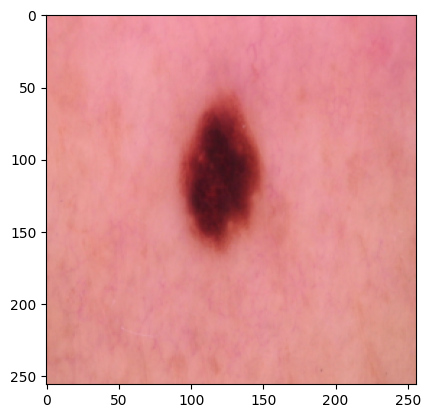

In [139]:
import matplotlib.pyplot as plt

# plt.imshow(isic_train_cutmixed[0][0][0].numpy().transpose(1,2,0) / 255)
# plt.show()

plt.imshow(isic_train[87][0].numpy().transpose(1,2,0) / 255)
plt.show()

In [22]:
torch.randint(low=0, high=10, size=(1,)).item()

9

### Demo

In [19]:

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import make_classification

X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X, y = X.astype(np.float32), y.astype(np.int64)
X.shape, y.shape, y.mean()

class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [ ]:
# net_2 = isic_skorch_trainer.net_fit(
#     isic_skorch_trainer.net_def(
#         ClassifierModule, 
#         net_name = 'eee',
#         classes=[torch.tensor, torch.tensor],    
#         classifier_kwargs = dict(
#             lr = 0.001,
#             train_split = isic_val_32,
#             callbacks = [
#                 ResetedSkorchLRScheduler('valid_f1', ['valid_acc', 'valid_f1', 'valid_loss'], 3,
#                     policy='StepLR', step_size=3, last_epoch = -1)]
#             )
#         ), 
# isic_train_32, None, 30)
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, EpochScoring, PrintLog
from sklearn.metrics import top_k_accuracy_score

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=50,
    lr=0.01,
#     device='cuda',  # uncomment this to train with CUDA
    device = 'mps', 
    callbacks = [
        EpochScoring(scoring='f1_macro', name='valid_f1',
                     lower_is_better=False),
        # EpochScoring(scoring=lambda net, X, y:top_k_accuracy_score(y, net.predict(X), k=1), name='valid_top_k_acc',
        #              lower_is_better=False),
        ResetedSkorchLRScheduler('valid_f1', ['valid_acc', 'valid_f1'], 10,
                    policy='StepLR', step_size=5, last_epoch = -1)
    ]
)

# Training the network
net.fit(X, y)